## Check observables given a results file from a `TRSL` simulation

We are checking:
1. Protein production rate
2. Ribosome speed
3. Ribosome density (TODO: compare with Siwiak)
4. Number of free ribosomes

In [5]:
import cPickle as pkl
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
from statsmodels.nonparametric.smoothers_lowess import lowess

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [6]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

The following pickle file contains the simulation results:

In [116]:
filepath = "../results/full transcriptome and exome, no decay, specific best estimate initiation rates according to Plotkin_20150923_1409_3600s.p"

Make file readable by `ipython` in case it was created by `pypy`:

In [117]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")

In [118]:
results = pkl.load(open(filepath))

### 1. Protein production rate

In [119]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

Plot some randomly selected timecourses:

In [120]:
size = 5
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

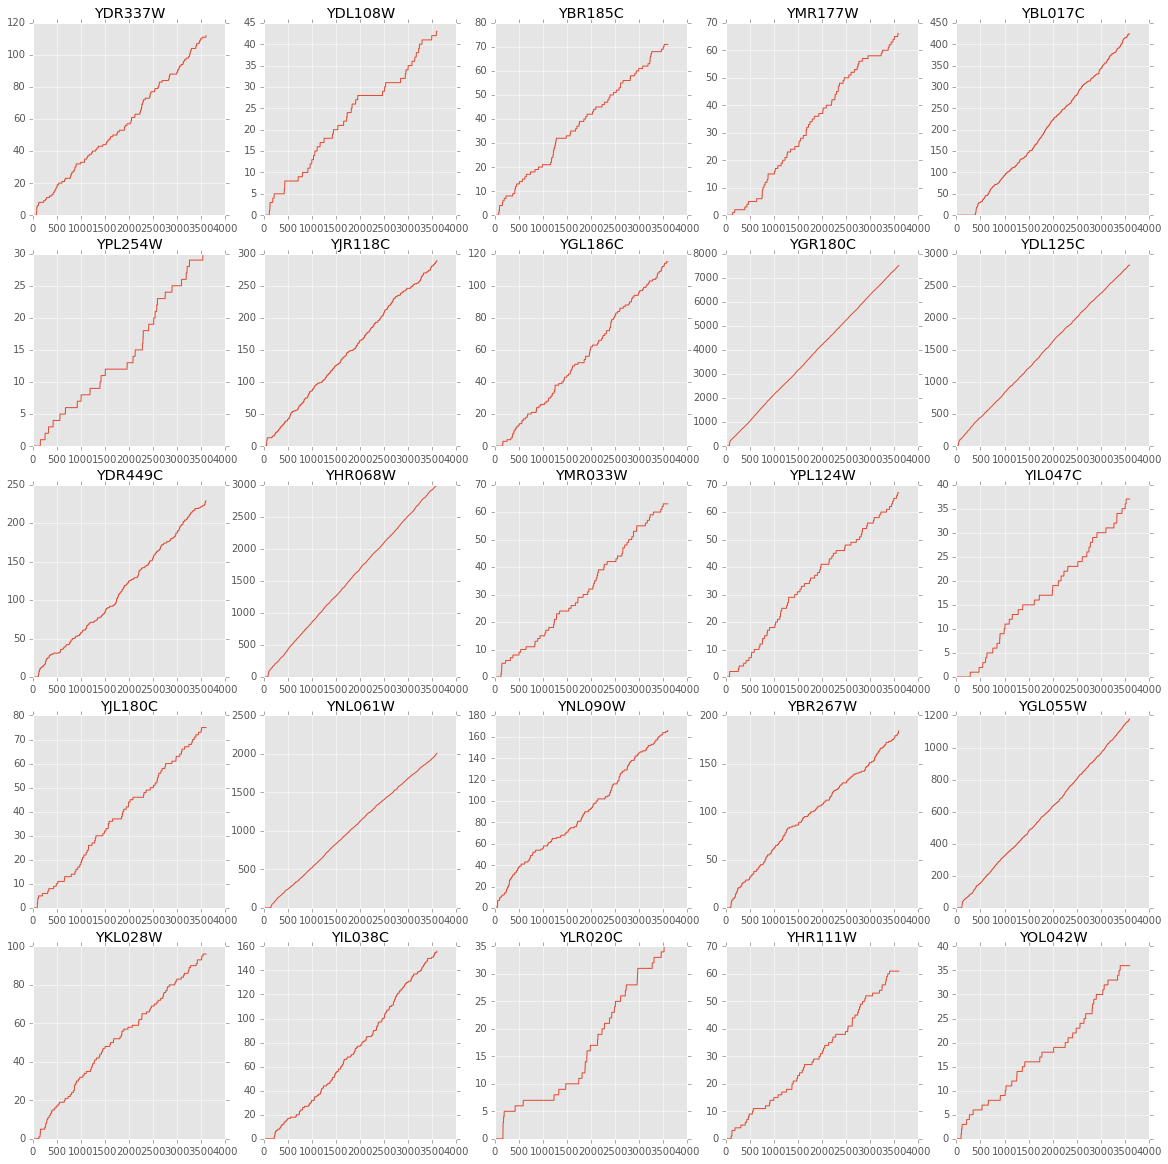

In [121]:
fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        ax[i, j].plot(results['timerange'], results['timecourses'][protnames_plot[i][j]])
        ax[i, j].set_title(protnames_plot[i][j])

For each protein, calculate speed of translation (TODO: start and stop should be automatic):

In [122]:
start, stop = 599, 3599  # to exclude the "burn in" phase
prot_speeds = {}

for prot in protnames:
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * stop - start)
    if prot_speeds[prot] > 50: 
        print prot, prot_speeds[prot]

YKL060C 61.5816666667
YAL038W 98.0956666667
YCR012W 58.3673333333
YLR044C 274.821666667
YOL040C 67.9613333333


In [123]:
pd.Series(prot_speeds.values()).describe()

count    2496.000000
mean        0.982536
std         6.985507
min         0.001333
25%         0.024667
50%         0.064333
75%         0.226833
max       274.821667
dtype: float64

Distribution of translation speeds (finished protein molecules per second, every protein is one datapoint):

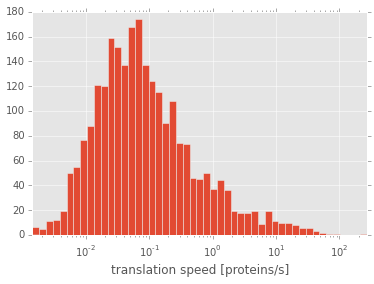

In [124]:
plt.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                              np.log10(max(prot_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
plt.gca().set_xlabel('translation speed [proteins/s]')
plt.show()

In [125]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [126]:
peptide_speeds = {prot: prot_speeds[prot] * len(orf_genomic_dict[prot]) / 3.0 for prot in prot_speeds}

In [127]:
pd.Series(peptide_speeds.values()).describe()

count      2496.000000
mean        357.928271
std        3504.372612
min           0.509667
25%           8.966750
50%          24.085667
75%          82.205500
max      154999.420000
dtype: float64

Distribution of speeds of peptide bond creation (peptide bonds per second, every protein is one datapoint):

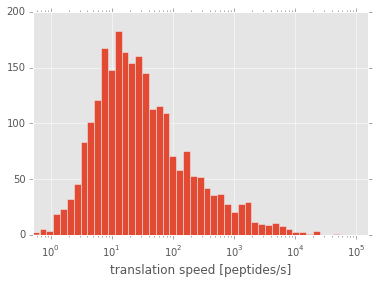

In [128]:
plt.hist(peptide_speeds.values(), bins = 10**np.linspace(np.log10(min(peptide_speeds.values())+0.0001), 
                                                              np.log10(max(peptide_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(peptide_speeds.values())+0.0001, max(peptide_speeds.values())])
plt.gca().set_xlabel('translation speed [peptides/s]')
plt.show()

Scatter plot speed, initiation rate and transcript abundance:

In [129]:
init_rates_plotkin = pkl.load(open('../parameters/init_rates_plotkin.p'))
print len(init_rates_plotkin)

2569


In [130]:
transcriptome_plotkin = pkl.load(open('../parameters/transcriptome_plotkin.p'))
print len(transcriptome_plotkin)
print sum(transcriptome_plotkin.values())

4839
60000


In [131]:
df1 = pd.DataFrame.from_dict(peptide_speeds.items())
df1.columns = ['name', 'peptide_speeds']

df2 = pd.DataFrame.from_dict(init_rates_plotkin.items())
df2.columns = ['name', 'init_rates_plotkin']

df3 = pd.DataFrame.from_dict(transcriptome_plotkin.items())
df3.columns = ['name', 'transcriptome_plotkin']

In [132]:
df = pd.merge(df1, df2, left_on='name', right_on='name', how='outer')
df = pd.merge(df, df3, left_on='name', right_on='name', how='outer')
df

,name,peptide_speeds,init_rates_plotkin,transcriptome_plotkin
0,YBR177C,58.006667,0.000002,8
1,YIL140W,43.397333,0.000001,5
2,YLR268W,32.035000,0.000002,10
3,YLR197W,1466.856667,0.000011,40
4,YAL008W,3.316667,0.000001,2
5,YOR043W,13.311333,0.000001,8
6,YJL122W,24.229333,0.000001,12
7,YCR093W,197.543000,0.000002,7
8,YIL050W,6.768667,0.000001,3
9,YLR244C,258.408000,0.000005,18


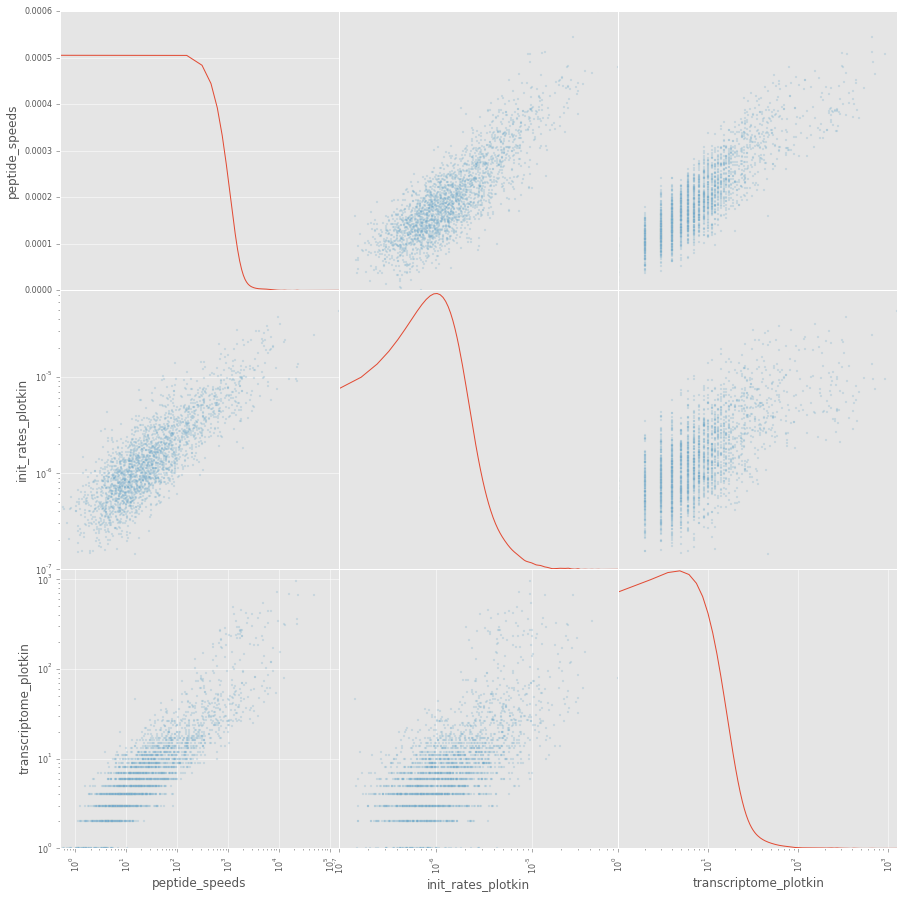

In [133]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0000001, df[df.columns[i+1]].min())
        minj = max(0.0000001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')         

Best predictor of peptide translation speed appears to be initiation rate but also transcript abundance has some effect.

### 2. Ribosome speed

We read a results dictionary which contains tic/toc results for the mRNAs:

In [134]:
filepath = "../results/full transcriptome and exome, no decay, specific best estimate initiation rates according to Plotkin_20150923_1409_3600s.p"

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [28]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")
results = pkl.load(open(filepath))

The following is smaller than 20000 (or 60000), probably because not for every gene in `transcriptome_plotkin_20000.p` there is an initiation rate available.

In [135]:
len(results['transcriptome'])

50243

In [136]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [137]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]]) for index in transcript_tic_toc}

In [138]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [139]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [140]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [141]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [142]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic_toc']

In [17]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [18]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [145]:
pd.Series(orf_lengths.values()).describe()

count     5917.000000
mean      1485.306236
std       1149.149051
min         51.000000
25%        711.000000
50%       1218.000000
75%       1887.000000
max      14733.000000
dtype: float64

In [146]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'orf_length']

In [147]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

Scatter plot of ORF lengths against ribosome runtimes:

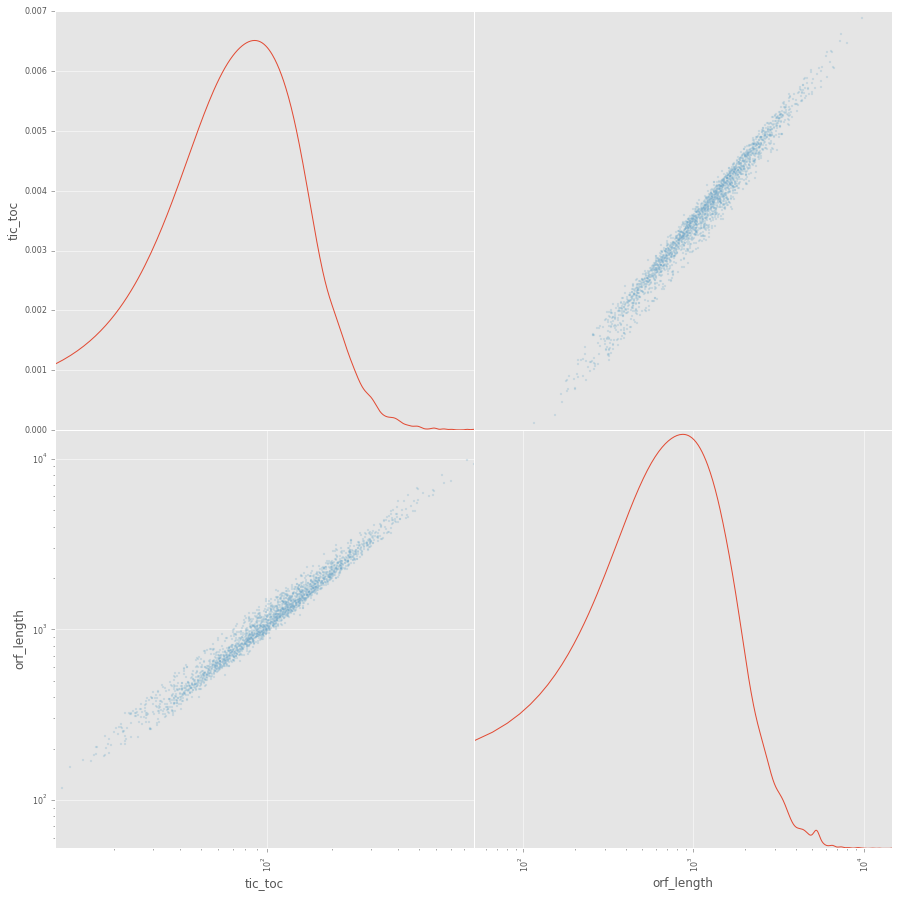

In [148]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0001, df[df.columns[i+1]].min())
        minj = max(0.0001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj+1, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini+1, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')            

In [149]:
ribo_inverse_speed_dict = {geneID: gene_tic_toc[geneID]/orf_lengths[geneID] for geneID in gene_tic_toc}

In [150]:
pd.Series(ribo_inverse_speed_dict.values()).describe()

count    2496.000000
mean        0.091816
std         0.009100
min         0.065594
25%         0.086340
50%         0.093006
75%         0.098164
max         0.122262
dtype: float64

Distribution of inverse ribosome speeds (seconds per nucleotide):

(array([   7.,    2.,    3.,   12.,   15.,   11.,   20.,   29.,   24.,
          29.,   24.,   33.,   30.,   34.,   54.,   42.,   49.,   52.,
          52.,   60.,   68.,   82.,   82.,   82.,  105.,   91.,  104.,
         114.,  125.,  141.,  116.,  125.,  109.,  104.,  100.,   75.,
          64.,   54.,   31.,   39.,   21.,   14.,    9.,   10.,   10.,
          16.,    9.,    3.,    2.,    2.,    1.,    2.,    2.,    1.,
           0.,    0.]),
 array([ 0.0655939,  0.0665939,  0.0675939,  0.0685939,  0.0695939,
         0.0705939,  0.0715939,  0.0725939,  0.0735939,  0.0745939,
         0.0755939,  0.0765939,  0.0775939,  0.0785939,  0.0795939,
         0.0805939,  0.0815939,  0.0825939,  0.0835939,  0.0845939,
         0.0855939,  0.0865939,  0.0875939,  0.0885939,  0.0895939,
         0.0905939,  0.0915939,  0.0925939,  0.0935939,  0.0945939,
         0.0955939,  0.0965939,  0.0975939,  0.0985939,  0.0995939,
         0.1005939,  0.1015939,  0.1025939,  0.1035939,  0.1045939,
      

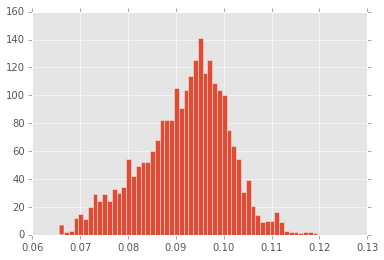

In [151]:
plt.hist(ribo_inverse_speed_dict.values(), bins=np.arange(min(ribo_inverse_speed_dict.values()), max(ribo_inverse_speed_dict.values()), 0.001))


In [152]:
ribo_speed_dict = {geneID: orf_lengths[geneID]/3.0/gene_tic_toc[geneID] for geneID in gene_tic_toc}

Translation speed distribution (codons per second):

(array([   3.,    7.,   33.,   39.,  102.,  220.,  318.,  348.,  297.,
         248.,  190.,  151.,  108.,   99.,   86.,   56.,   49.,   41.,
          41.,   21.,   22.,    8.,    5.]),
 array([ 2.72637506,  2.82637506,  2.92637506,  3.02637506,  3.12637506,
         3.22637506,  3.32637506,  3.42637506,  3.52637506,  3.62637506,
         3.72637506,  3.82637506,  3.92637506,  4.02637506,  4.12637506,
         4.22637506,  4.32637506,  4.42637506,  4.52637506,  4.62637506,
         4.72637506,  4.82637506,  4.92637506,  5.02637506]),
 <a list of 23 Patch objects>)

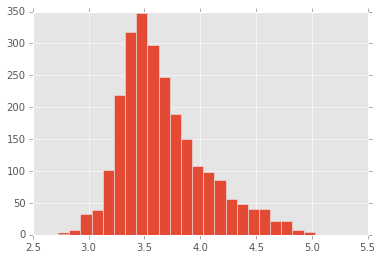

In [153]:
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.1))

TODO: Check against CAI

### 3. Ribosome density

Definition of ribosome density: average number of ribosomes per codon

Can depend on:

a) time - zero at first, reaches steady state (not discussed further)

b) position - density might be high at 5' end if initation rate is higher than rate at which ribosomes are transported away from initiation site

In [2]:
import shelve

filepath = "../results/ribosome_timecourses_full transcriptome and exome, no decay, specific best estimate initiation rates according to Plotkin_20150923_1848.db"
d = shelve.open(filepath)

In [3]:
resultsfile = "../results/full transcriptome and exome, no decay, specific best estimate initiation rates according to Plotkin_20150923_1847_1200s.p"

In [7]:
replace(resultsfile, "_numpypy.multiarray", "numpy.core.multiarray")

In [8]:
results = pkl.load(open(resultsfile))

Populate a dictionary with ribosome "lattices":

In [9]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last to catch steady state
    # Select only every third element (the others are zero anyway):
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

To make the ribosomes into a data frame, all array have to have the same length:

In [10]:
max_codons = len(max(ribo_lattice_dict.values(), key=len))

for gene in ribo_lattice_dict:
    ribo_lattice_dict[gene] = np.append(ribo_lattice_dict[gene], [None] * (max_codons - len(ribo_lattice_dict[gene])))

In [11]:
ribo_lattice_df = pd.DataFrame.from_dict(ribo_lattice_dict)
ribo_lattice_df

,YAL001C,YAL003W,YAL007C,YAL008W,YAL012W,YAL016W,YAL022C,YAL023C,YAL025C,YAL029C,YAL033W,YAL035W,YAL036C,YAL038W,YAL042W,YAL044C,YAL046C,YAL059W,YAL060W,YAR002W,
0,0,10,0,0,2,0,0,0,0,0,0,2,1,42,0,0,0,0,0,0,...
1,0,10,0,0,1,0,0,0,0,0,0,0,0,13,0,1,0,0,0,0,...
2,0,4,0,0,1,0,0,0,0,0,0,0,0,20,1,0,0,0,0,0,...
3,0,6,1,0,1,0,0,0,0,0,0,0,1,12,0,0,0,0,0,0,...
4,0,8,0,0,0,0,0,1,0,0,0,0,0,8,0,0,0,0,0,0,...
5,0,3,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,...
6,0,11,0,0,3,0,0,1,0,0,0,0,0,16,0,1,0,0,0,0,...
7,0,3,1,0,2,0,0,1,0,0,0,0,0,12,0,0,0,0,0,0,...
8,0,1,0,0,2,0,0,0,0,0,0,0,0,40,0,0,0,0,0,1,...
9,0,4,0,0,3,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,...


Check number of ribosomes in this data frame:

In [12]:
sum(dict(ribo_lattice_df.sum()).values())

178063.0

It is more convenient to remove the None values from `ribo_lattice_dict`:

In [40]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last to catch steady state
    # Select only every third element (the others are zero anyway):
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

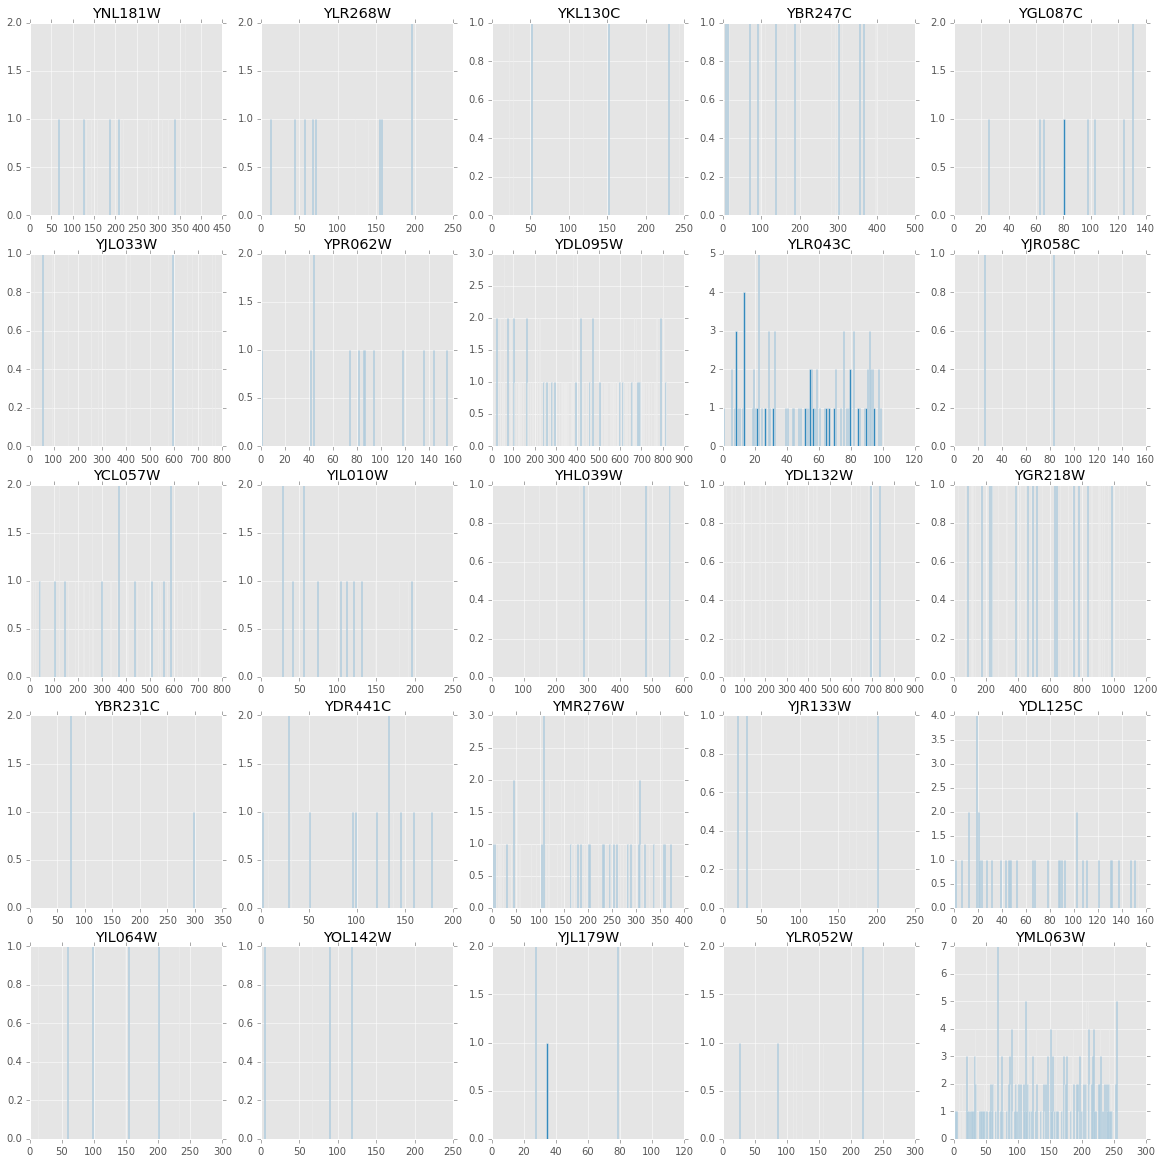

In [41]:
size = 5
genenames_plot = np.array(random.sample(ribo_lattice_dict.keys(), size*size))
genenames_plot.shape = (size, size)

fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        plotlist = [elem for elem in ribo_lattice_dict[genenames_plot[i][j]]]
        ax[i, j].bar(range(len(plotlist)), plotlist)
        ax[i, j].set_title(genenames_plot[i][j])   


Average ribosome number per gene (average along the mRNA, across all codons):

In [42]:
average_ribos_per_gene = dict(ribo_lattice_df.mean(numeric_only=None))

Function to plot two dictionaries by their values:

In [15]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)

    scat = plt.scatter(xs, ys)
    scat.set_alpha(0.2)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs)[:,1]
    plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    plt.show()

Scatter plot against ORF lengths (mostly to rule out a mistake with the different lengths):

2405


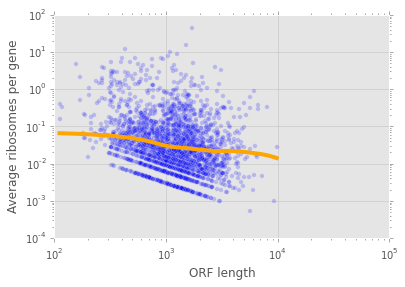

In [19]:
scatter_dicts(orf_lengths, {gene: average_ribos_per_gene[gene] for gene in average_ribos_per_gene 
                                if average_ribos_per_gene[gene] > 1e-16}, 'ORF length', 'Average ribosomes per gene')

No recognizable correlation - probably correct!

This means dividing by the length takes care of the correlation.

Normalize by transcript abundance:

In [20]:
transcriptome = pkl.load(open("../parameters/transcriptome_plotkin.p", "rb"))
init_rates = pkl.load(open("../parameters/init_rates_plotkin.p", "rb"))

In [21]:
print len(transcriptome)
print sum(transcriptome.values())

4839
60000


In [22]:
average_ribos_per_transcript = {gene: np.mean(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene]))                                
                                for gene in ribo_lattice_df
                                if np.mean(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene])) > 1e-16}

In [23]:
total_ribos_per_transcript = {gene: sum(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene]))                                
                                for gene in ribo_lattice_df
                                if sum(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene])) > 1e-16}

Plot against ORF length:

2405


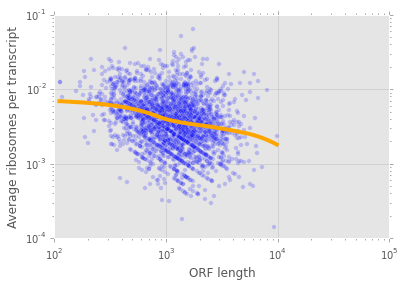

In [24]:
scatter_dicts(orf_lengths, average_ribos_per_transcript, 'ORF length', 'Average ribosomes per transcript')

2405


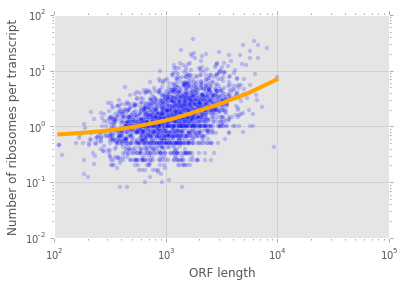

In [25]:
scatter_dicts(orf_lengths, total_ribos_per_transcript, 'ORF length', 'Number of ribosomes per transcript')

Plot against initiation rate:

2405


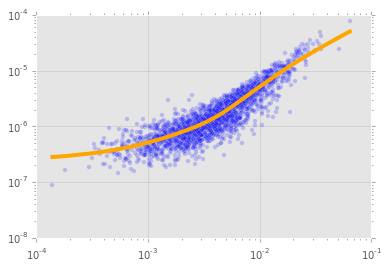

In [26]:
scatter_dicts(average_ribos_per_transcript, init_rates)

TODO: what explains the remaining dispersion? TODO: check CAI?

Analysis by codon position:

In [27]:
for column in ribo_lattice_df:
    ribo_lattice_df[column] = ribo_lattice_df[column]/float(transcriptome[column])

In [28]:
means_per_position = ribo_lattice_df.mean(axis=1, numeric_only=None)
means_per_position

0     0.006410
1     0.005774
2     0.004323
3     0.005795
4     0.004762
5     0.004453
6     0.005388
7     0.005150
8     0.005548
9     0.005287
10    0.005837
11    0.005450
12    0.005521
13    0.005339
14    0.005793
...
3254    0
3255    0
3256    0
3257    0
3258    0
3259    0
3260    0
3261    0
3262    0
3263    0
3264    0
3265    0
3266    0
3267    0
3268    0
Length: 3269, dtype: float64

In [29]:
positions = len(means_per_position)
# not all genes in the transcriptome have an orf_length, why?
transcripts_per_position = [sum([transcriptome[gene] for gene in transcriptome 
                            if gene in orf_lengths and position+1 <= orf_lengths[gene]/3])
                            for position in range(positions)]
len(transcripts_per_position)

3269

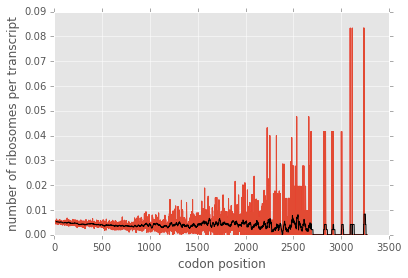

In [36]:
ts = means_per_position
ts.plot(style='r').set_xlabel('codon position')
ts.plot().set_ylabel('number of ribosomes per transcript')
#plt.xlim([0, 500])
#plt.ylim([0, 0.01])
#plt.yscale('log') 
pd.rolling_mean(ts, 20).plot(style='k')

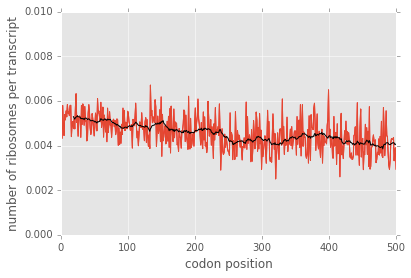

In [31]:
ts = means_per_position
ts.plot(style='r').set_xlabel('codon position')
ts.plot().set_ylabel('number of ribosomes per transcript')
plt.xlim([0, 500])
plt.ylim([0, 0.01])
pd.rolling_mean(ts, 20).plot(style='k')

Let us try on single genes:

Find gene with maximum transcription (for best statistics):

In [32]:
maxgene = max(transcriptome.iterkeys(), key=(lambda key: transcriptome[key]))
maxgene, transcriptome[maxgene]

('YLR044C', 1283)

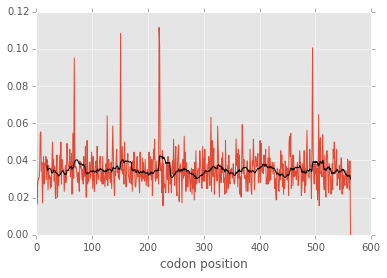

In [33]:
ribo_lattice_df[maxgene].plot().set_xlabel('codon position')
pd.rolling_mean(ribo_lattice_df[maxgene], 20).plot(style='k')

No ribosome ramp at individual gene level? This would be consistent with Shah's hypothesis that it is caused by short genes with high initiation probabilities. 

TODO: we need to check this more systematically.

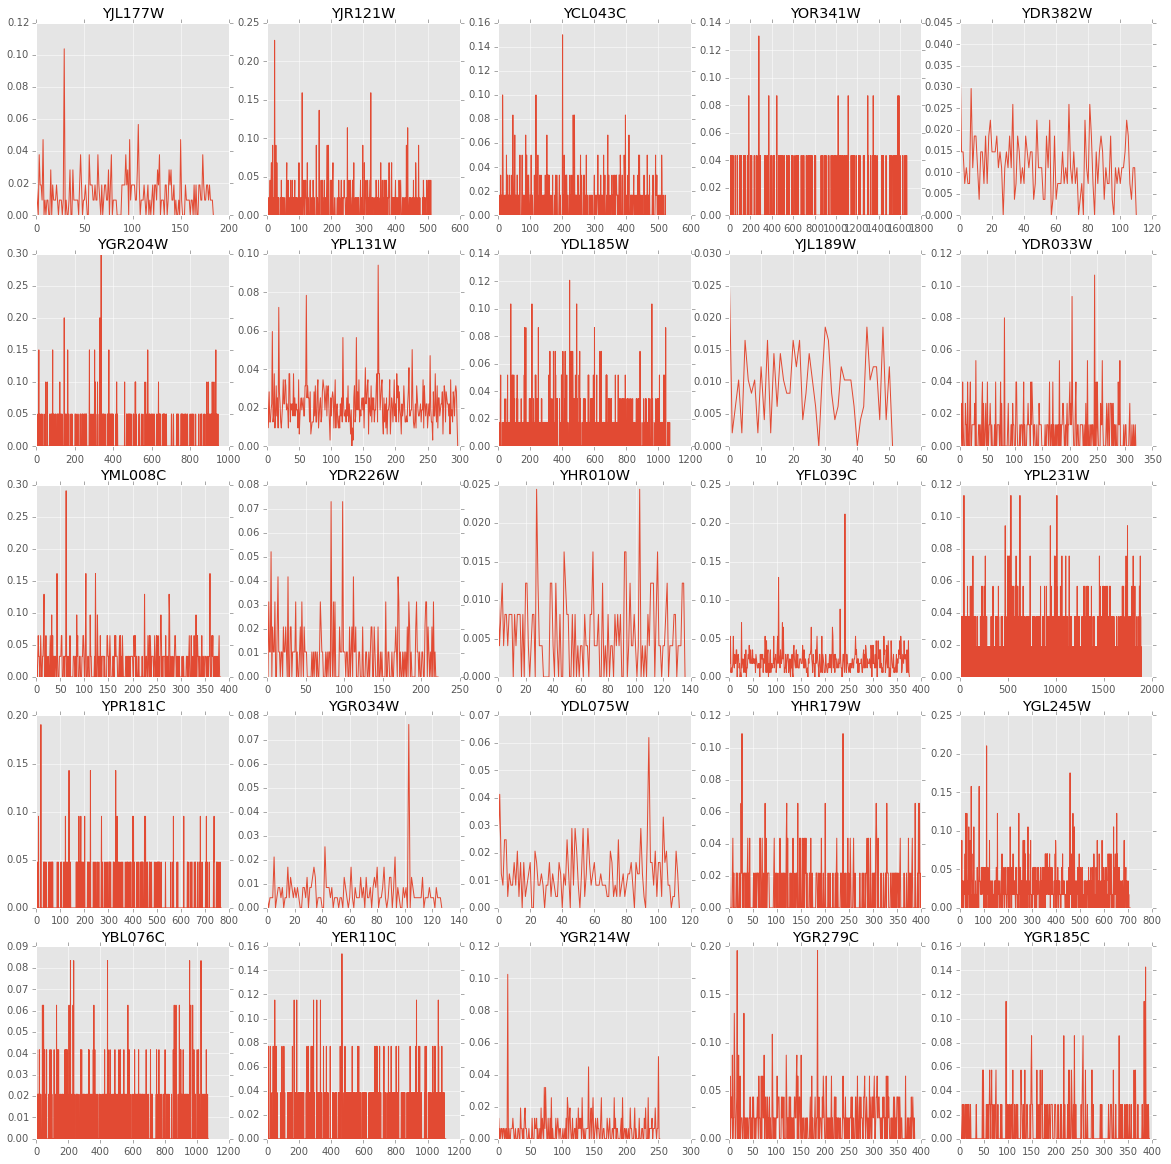

In [43]:
high_transcript_abundance_genes = [gene for gene in ribo_lattice_dict 
                                   if sum([elem for elem in ribo_lattice_dict[gene]]) > 150]

size = 5
genenames_plot = np.array(random.sample(high_transcript_abundance_genes, size*size))
genenames_plot.shape = (size, size)

fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        plotlist = [elem for elem in ribo_lattice_dict[genenames_plot[i][j]] if elem is not None]
        ax[i, j].plot(ribo_lattice_df[genenames_plot[i][j]])
        #ax[i, j].set_xlabel('codon position')
        ax[i, j].set_title(genenames_plot[i][j])   


To calculate the SNR, we establish standard deviations and maxima of the ribosome densities:

In [54]:
sigmas = {gene: np.std(ribo_lattice_dict[gene]/float(transcriptome[gene])) for gene in ribo_lattice_dict}
peaks = {gene: np.max(ribo_lattice_dict[gene]/float(transcriptome[gene])) for gene in ribo_lattice_dict}

In [56]:
SNRs = {gene: peaks[gene]/sigmas[gene] for gene in ribo_lattice_dict if sigmas[gene]!=0}

In [57]:
SNRs

{'YBR177C': 4.647216084512543,
 'YIL140W': 7.7378567321810126,
 'YLR268W': 8.0321232242280409,
 'YIR004W': 14.748038526232255,
 'YAL008W': 10.025475165011594,
 'YOR043W': 7.8671279042213627,
 'YJL122W': 6.4568137765740614,
 'YCR093W': 11.737242990899896,
 'YLR244C': 6.4818889718976829,
 'YPL144W': 8.6898564684450879,
 'YJR084W': 20.615585465035792,
 'YBR135W': 4.7560529520327721,
 'YBR004C': 9.3707873207994954,
 'YBR160W': 17.320604946268443,
 'YHR007C': 5.9238572332802306,
 'YLR197W': 10.773031160697137,
 'YKL190W': 3.4785054261852153,
 'YGL215W': 5.7783244559071694,
 'YLR348C': 6.6134906302969521,
 'YBR248C': 6.8633457205184714,
 'YNR067C': 5.6647001045592766,
 'YKL063C': 7.1505548583734946,
 'YFL045C': 4.889801313793904,
 'YFL010C': 5.0562253949558107,
 'YIL124W': 7.1194953902556817,
 'YJR044C': 4.3226323433690119,
 'YMR009W': 6.7840052529996759,
 'YJL179W': 7.0820505797761424,
 'YKL183W': 7.9004149442539022,
 'YLR362W': 18.973739570682756,
 'YLR220W': 6.867678577335405,
 'YBR273C':

### 4. Number of free ribosomes

In [ ]:
results["timecourses"]["ribos._free"]

Time course plots would be interesting... (oscillation!)